In [1]:
"""
Preprocess_single_channel_recordings.ipynb
Lukasz Radzinski
Charite Neurophysics Group, Berlin
Script for preprocessing single channel,
separate MEG/EEG recordings 
"""

'\nPreprocess_single_channel_recordings.ipynb\nLukasz Radzinski\nCharite Neurophysics Group, Berlin\nScript for preprocessing single channel,\nseparate MEG/EEG recordings \n'

In [2]:
import os
import sys
import meet
import scipy
import tables
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy import signal as sig
import helper_scripts.helper_functions as helper_functions

# set global parameters for plots
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['savefig.dpi'] = 600

In [3]:
# select subject [S1-S7] and measurement type [MEG, EEG]

filename = 'S1_MEG_only_sc_stim'
date = '2018-03-19'
#date = '2023-11-15'
#date = '2024-06-25'
additional_plot_title = ''

filename_splitted = filename.split('_')
subject = filename_splitted[0]
measurement_type = filename_splitted[1]

if(filename_splitted[2] == 'comb'):
    combined_MEEG = True
elif(filename_splitted[2] == 'only'):
    combined_MEEG = False

if(filename_splitted[3] == 'mc'):
    multichannel = True
elif(filename_splitted[3] == 'sc'):
    multichannel = False

recording_condition = filename_splitted[4]

data_input_folder = '../Data/raw_data'
data_output_folder = '../Data/cleaned_data'
plots_output_folder = '../Results'

use_brown_noise = False

data_input_folder = os.path.join(data_input_folder, date, subject)
data_output_folder = os.path.join(data_output_folder, date, subject)
plots_output_folder = os.path.join(plots_output_folder, subject, 'preprocessing', date+'_'+filename)

if(measurement_type == 'MEG'):
    srate = 20000
    unit = 'B [fT]'
    asd_unit = '[fT/√HZ]'
elif(measurement_type == 'EEG'):
    srate = 10000
    unit = 'U [μV]'
    asd_unit = '[μV/√HZ]'

if(multichannel):
    sys.exit(0)

In [4]:
# load the data

if(measurement_type == 'MEG'):
    raw_data = helper_functions.readMEG(os.path.join(data_input_folder, filename+'.dat'), s_rate=srate, num_chans=2)
elif(measurement_type == 'EEG'):
    h5file_eeg_stim = tables.open_file(os.path.join(data_input_folder, filename+'.hdf5'), mode="r", title="%s_eeg_stim" % subject)
    raw_data = np.array(h5file_eeg_stim.root.EEG_data).T

In [5]:
# extract the signals
if(measurement_type == 'MEG'):
    # change polarity of the MEG data to
    # make it consistent with the EEG data
    XEG_raw_data = -raw_data[0]
    stimulus_data = raw_data[-1]
elif(measurement_type == 'EEG'):
    # remove first 5 seconds and use the offset
    # to align the EEG data to the stimulus
    offset = 40
    XEG_raw_data = raw_data[0][5*srate+offset:]
    stimulus_data = raw_data[-1][5*srate:-offset]

In [6]:
# using brownian noise as a test reference
if(use_brown_noise):
    import colorednoise as cn
    if(measurement_type == 'MEG'):
        XEG_raw_data = 10000*cn.powerlaw_psd_gaussian(2, len(XEG_raw_data))
    elif(measurement_type == 'EEG'):
        XEG_raw_data = 1000*cn.powerlaw_psd_gaussian(2, len(XEG_raw_data))

In [7]:
# add header to the plot function
def plt_header(main_title=''):

    title = filename+', '+date
    title += '\n'+main_title+additional_plot_title

    plt.title(title)

In [8]:
# show and save the plot function
def plt_show_save_fig(fig_name=None):

    if(fig_name):
        fig_name += '.png'
    else:
        plt_show_save_fig.counter += 1
        fig_name = 'Fig%02d.png' % plt_show_save_fig.counter

    print('--------------------\n'+fig_name)
    os.makedirs(plots_output_folder, exist_ok=True)
    plt.savefig(os.path.join(plots_output_folder, fig_name), bbox_inches='tight')
    plt.show()

plt_show_save_fig.counter = 0

--------------------
Fig01.png


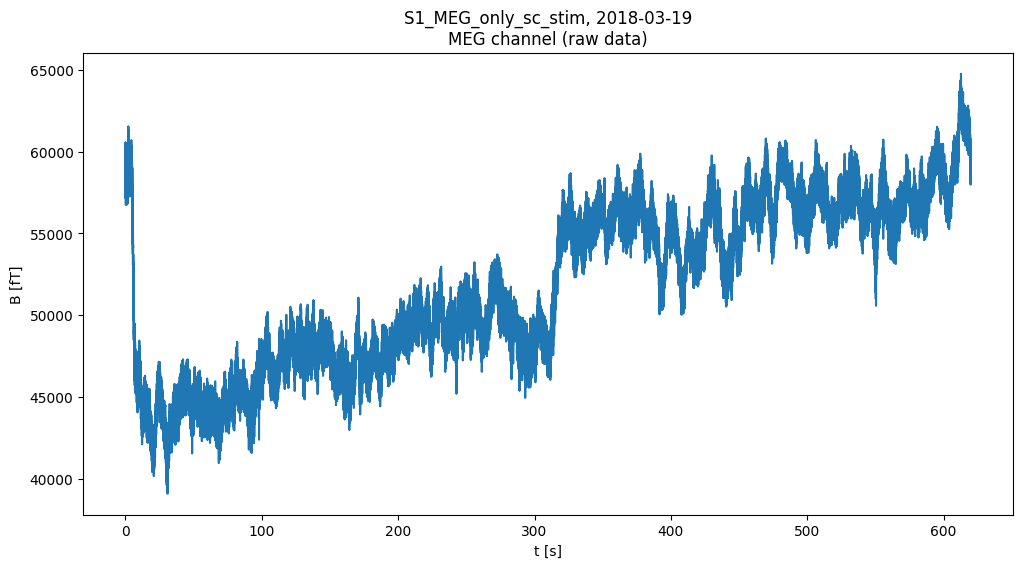

In [9]:
# plot the whole XEG signal

data = XEG_raw_data
data_x = np.linspace(0, (len(data)-1)/srate, len(data))
data_y = data

plt_header('%s channel (raw data)' % (measurement_type))
plt.plot(data_x, data_y)
plt.xlabel('t [s]')
plt.ylabel(unit)
plt_show_save_fig()

--------------------
Fig02.png


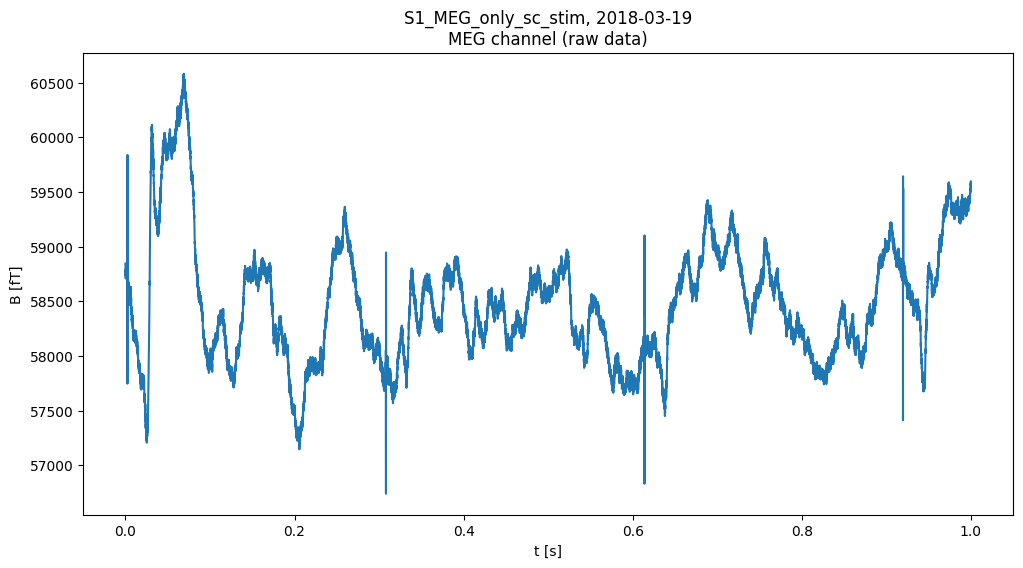

--------------------
Fig03.png


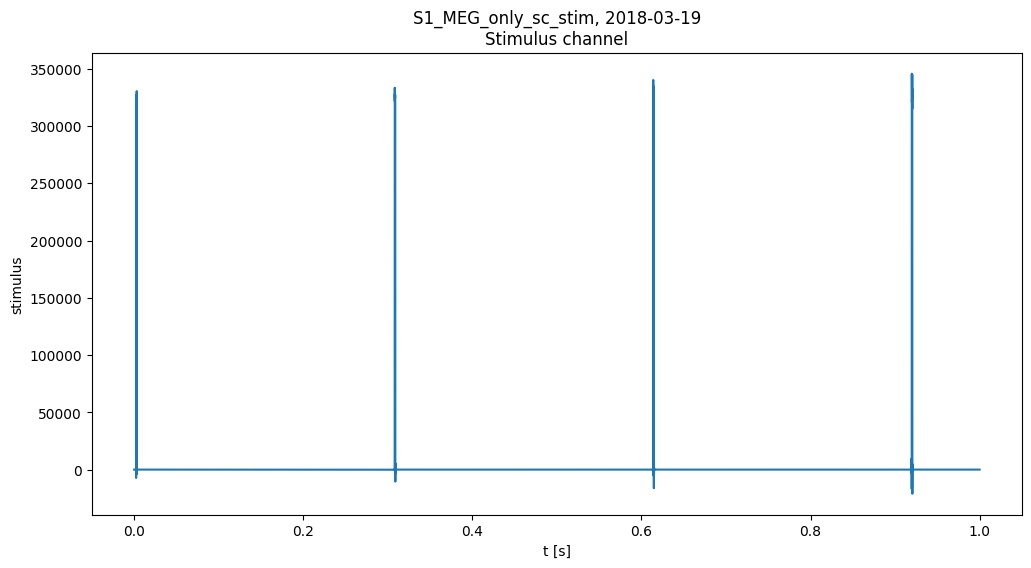

--------------------
Fig04.png


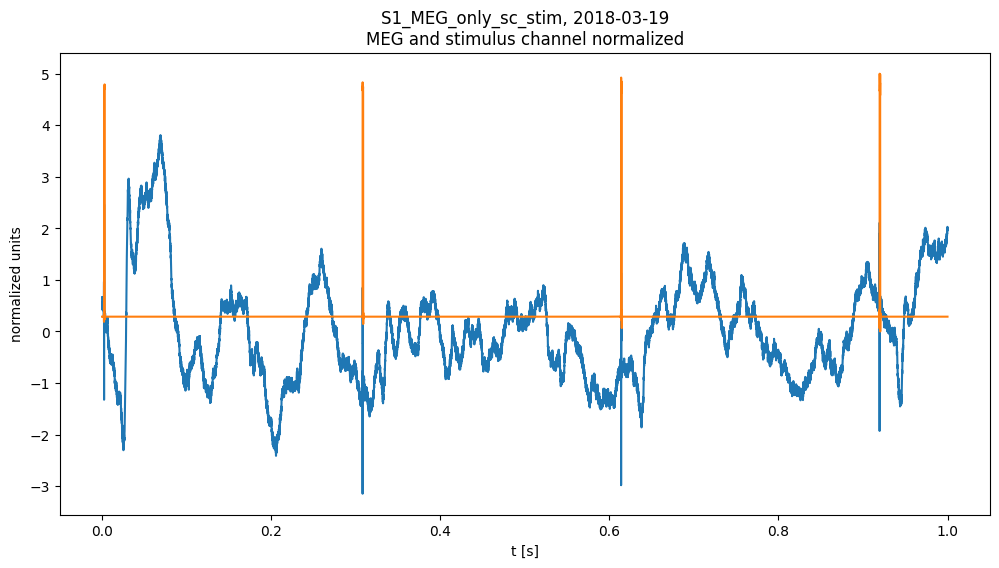

In [10]:
# plot XEG and stimulus signals

data = XEG_raw_data[:srate]
data_x = np.linspace(0, (len(data)-1)/srate, len(data))
data_y = data

plt_header('%s channel (raw data)' % (measurement_type))
plt.plot(data_x, data_y)
plt.xlabel('t [s]')
plt.ylabel(unit)
plt_show_save_fig()


data = stimulus_data[:srate]
data_x = np.linspace(0, (len(data)-1)/srate, len(data))
data_y = data

plt_header('Stimulus channel')
plt.plot(data_x, data_y)
plt.xlabel('t [s]')
plt.ylabel('stimulus')
plt_show_save_fig()


data = XEG_raw_data[:srate]
data = data - np.mean(data)
data = data / np.std(data)
data_x = np.linspace(0, (len(data)-1)/srate, len(data))
data_y = data

plt_header('%s and stimulus channel normalized' % (measurement_type))
plt.plot(data_x, data_y, label='MEG channel')
plt.xlabel('t [s]')
plt.ylabel('stimulus')

data = stimulus_data[:srate]
data = data - np.min(data)
data = data / np.max(data)
data *= 5
data_x = np.linspace(0, (len(data)-1)/srate, len(data))
data_y = data

plt.plot(data_x, data_y, label='stimulus channel')
plt.xlabel('t [s]')
plt.ylabel('normalized units')
plt_show_save_fig()

In [11]:
# get the stimuli positions
if(recording_condition != 'stim'):
    trial_len = int(srate/1)
    number_of_trials = int(len(XEG_raw_data)/trial_len)
    all_stimuli = np.arange(number_of_trials)*trial_len
    all_stimuli = all_stimuli[1:]
elif(measurement_type == 'MEG'):
    all_stimuli = ((stimulus_data[1:]>250000) & (stimulus_data[:-1]<250000)).nonzero()[0]
elif(measurement_type == 'EEG'):
    all_stimuli = ((stimulus_data[1:]>0.5) & (stimulus_data[:-1]<0.5)).nonzero()[0]

# get the marker, omit the first and last (avoid edge effects)
marker = all_stimuli[1:-1]

In [12]:
# remove the stimuli

if(measurement_type == 'EEG'):
    interpolate_win_ms = [-5, 5]
if(measurement_type == 'MEG'):
    interpolate_win_ms = [-2, 3]
interpolate_win = np.round(np.array(interpolate_win_ms) / 1000. * srate).astype(int)
XEG_stimuli_removed_data = meet.interpolateEEG(XEG_raw_data.copy(), all_stimuli, interpolate_win)

--------------------
Fig05.png


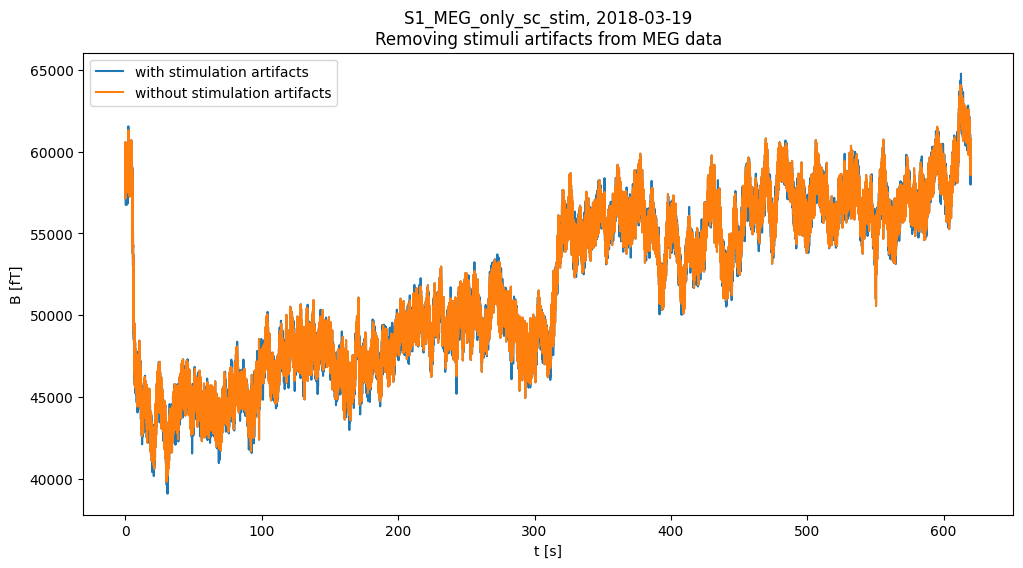

--------------------
Fig06.png


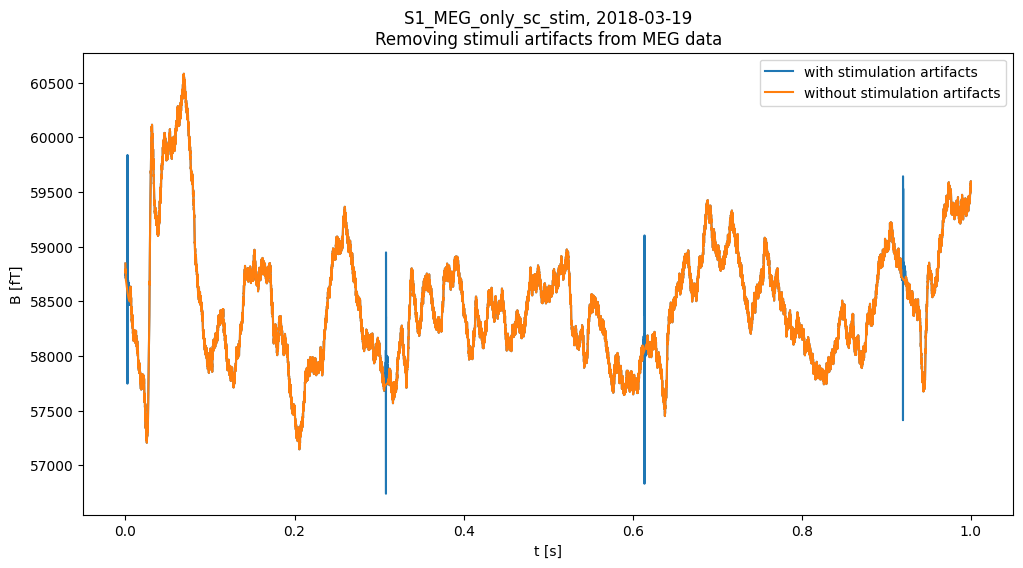

--------------------
Fig07.png


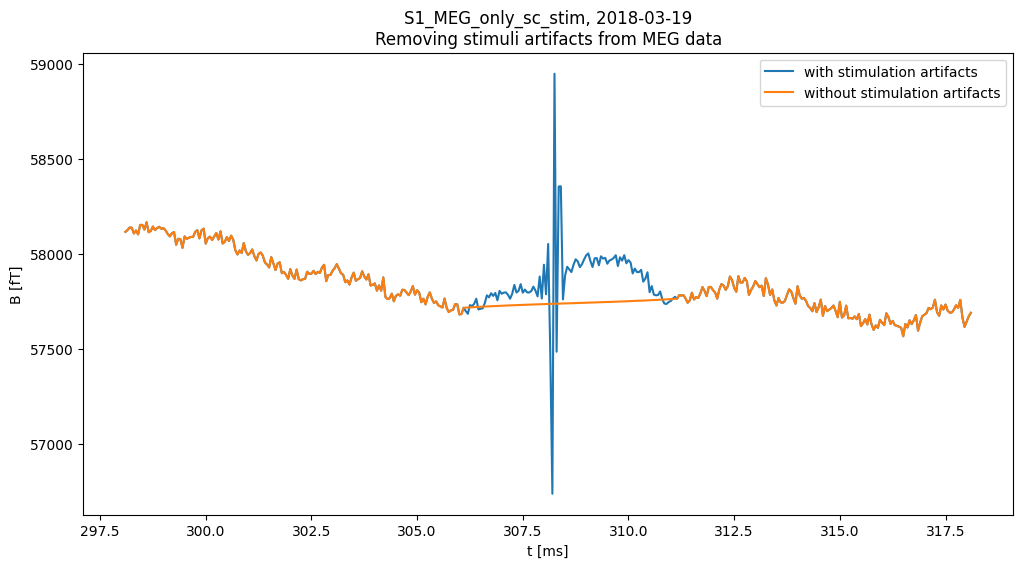

In [13]:
# plot signal without stimuli

data = XEG_raw_data
data_x = np.linspace(0, (len(data)-1)/srate, len(data))
data_y = data
plt.plot(data_x, data_y, label='with stimulation artifacts')

data = XEG_stimuli_removed_data
data_x = np.linspace(0, (len(data)-1)/srate, len(data))
data_y = data
plt.plot(data_x, data_y, label='without stimulation artifacts')

plt_header('Removing stimuli artifacts from %s data' % measurement_type)
plt.xlabel('t [s]')
plt.ylabel(unit)
plt.legend()
plt_show_save_fig()


data = XEG_raw_data[:srate]
data_x = np.linspace(0, (len(data)-1)/srate, len(data))
data_y = data
plt.plot(data_x, data_y, label='with stimulation artifacts')

data = XEG_stimuli_removed_data[:srate]
data_x = np.linspace(0, (len(data)-1)/srate, len(data))
data_y = data
plt.plot(data_x, data_y, label='without stimulation artifacts')

plt_header('Removing stimuli artifacts from %s data' % measurement_type)
plt.xlabel('t [s]')
plt.ylabel(unit)
plt.legend()
plt_show_save_fig()


start_time = marker[0]/srate - 0.01 
end_time = marker[0]/srate + 0.01

data = XEG_raw_data[int(start_time*srate):int(end_time*srate)]
data_x = np.linspace(start_time*1000, end_time*1000, len(data))
data_y = data
plt.plot(data_x, data_y, label='with stimulation artifacts')

data = XEG_stimuli_removed_data[int(start_time*srate):int(end_time*srate)]
data_x = np.linspace(start_time*1000, end_time*1000, len(data))
data_y = data
plt.plot(data_x, data_y, label='without stimulation artifacts')

plt_header('Removing stimuli artifacts from %s data' % measurement_type)
plt.xlabel('t [ms]')
plt.ylabel(unit)
plt.legend()
plt_show_save_fig()

In [14]:
# apply fc=1Hz hp filter to remove DC component

sos = sig.butter(2, 1, 'highpass', fs=srate, output='sos')
XEG_data = sig.sosfiltfilt(sos, XEG_stimuli_removed_data)

--------------------
Fig08.png


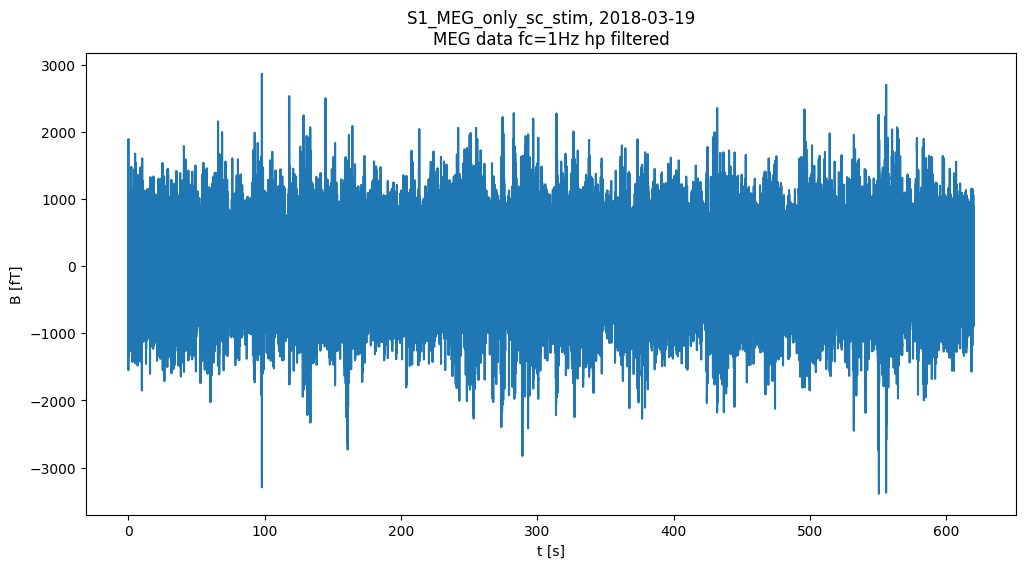

In [15]:
# plot signal without DC component

data = XEG_data
data_x = np.linspace(0, (len(data)-1)/srate, len(data))
data_y = data
plt.plot(data_x, data_y)

plt_header('%s data fc=1Hz hp filtered' % measurement_type)
plt.xlabel('t [s]')
plt.ylabel(unit)
plt_show_save_fig()

In [16]:
# calculate amplitude spectral density

def asd(data, nfft):

    yf, xf = mlab.psd(x=data, NFFT=nfft, Fs=srate, window=sig.windows.hann(nfft), noverlap=nfft//2)
    
    return xf, np.sqrt(yf)

--------------------
Fig09.png


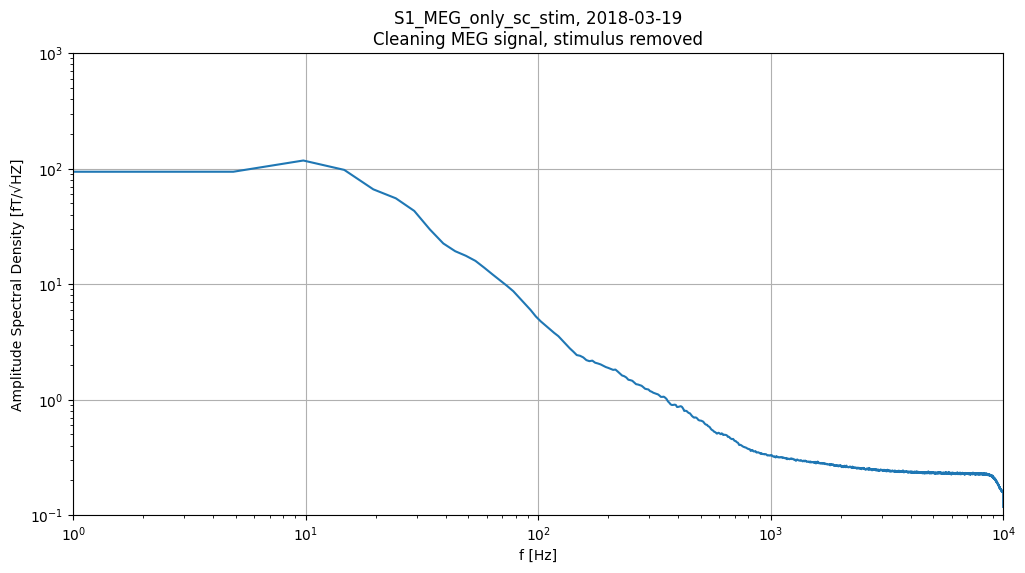

In [17]:
# plot asd of signal after removing stimulus

data = XEG_data
nfft = 2**(int(np.log2(srate))-2)
xf, yf = asd(data, nfft)

plt_header('Cleaning %s signal, stimulus removed' % measurement_type)
plt.plot(xf, yf)

plt.xscale('log')
plt.yscale('log')
plt.xlim((1,srate//2))
if(measurement_type == 'EEG'):
    plt.ylim((0.001, 10))
else:
    plt.ylim((0.1, 1000))
plt.xlabel('f [Hz]')
plt.ylabel('Amplitude Spectral Density %s' % asd_unit)
plt.grid(True)
plt_show_save_fig()

In [18]:
# remove powerline artifacts / spectrum peaks

XEG_with_spectrum_peaks = XEG_data

if(date == '2023-11-15'):

    # apply notch filter to remove powerline artifacts
    import mne
    info = mne.create_info(ch_names=['ch1'], sfreq=srate, ch_types=['eeg'])
    raw = mne.io.RawArray([XEG_data], info)

    # first filtering round
    powerline_freqs = []
    for i in range(50):
        powerline_freqs.append((2*i+1)*50)
    raw = raw.notch_filter(freqs=powerline_freqs, method="spectrum_fit")
    peaks_to_remove = powerline_freqs

    # second filtering round
    powerline_freqs = []
    for i in range(20):
        powerline_freqs.append((2*i+1)*50)
    raw = raw.notch_filter(freqs=powerline_freqs, method="spectrum_fit")
    XEG_data = raw['ch1'][0][0]

    # reinterpolate the stimulus to remove filtering artifacts
    XEG_data = meet.interpolateEEG(XEG_data, marker, interpolate_win)

else:

    # detect peaks in the spectrum
    nfft = 2**(int(np.log2(srate))-2)
    data = XEG_data
    xf, yf = asd(data, nfft)

    yf_norm = np.log10(yf)
    yf_norm = yf_norm - np.mean(yf_norm)
    yf_norm = yf_norm / np.std(yf_norm)
    asd_peaks = sig.find_peaks(yf_norm, prominence=2)[0]
    peaks_to_remove = xf[asd_peaks]

    if(len(peaks_to_remove) > 0):

        import mne
        info = mne.create_info(ch_names=['ch1'], sfreq=srate, ch_types=['eeg'])
        raw = mne.io.RawArray([XEG_data], info)

        # filtering
        raw = raw.notch_filter(freqs=peaks_to_remove, method="spectrum_fit")
        XEG_data = raw['ch1'][0][0]

        # reinterpolate the stimulus to remove filtering artifacts
        XEG_data = meet.interpolateEEG(XEG_data, marker, interpolate_win)

        # apply low-pass filter to remove potential artifact near Nyquist freqency
        sos = sig.butter(2, srate//2-100, 'lowpass', fs=srate, output='sos')
        XEG_data = sig.sosfiltfilt(sos, XEG_data)

--------------------
Fig10.png


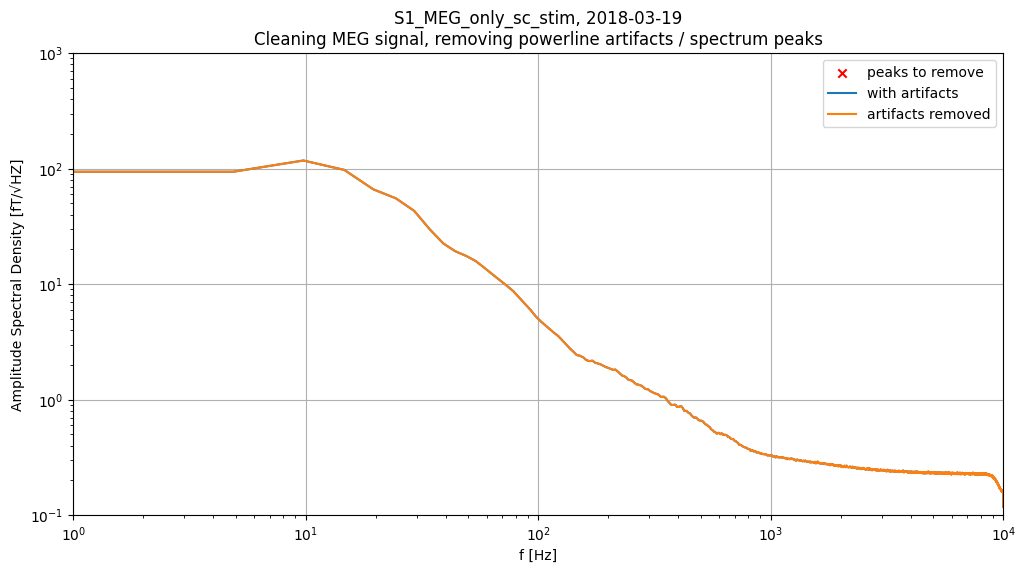

In [19]:
# plot asd of signal without powerline artifacts / spectrum peaks

data = XEG_with_spectrum_peaks
nfft = 2**(int(np.log2(srate))-2)
xf, yf = asd(data, nfft)

plt_header('Cleaning %s signal, removing powerline artifacts / spectrum peaks' % measurement_type)
plt.scatter(xf[asd_peaks], yf[asd_peaks], marker='x', color='red', label='peaks to remove')
plt.plot(xf, yf, label='with artifacts')

data = XEG_data
xf, yf = asd(data, nfft)

plt.plot(xf, yf, label='artifacts removed')
plt.xscale('log')
plt.yscale('log')
plt.xlim((1,srate//2))
if(measurement_type == 'EEG'):
    plt.ylim((0.001, 10))
else:
    plt.ylim((0.1, 1000))
plt.xlabel('f [Hz]')
plt.ylabel('Amplitude Spectral Density %s' % asd_unit)
plt.legend()
plt.grid(True)
plt_show_save_fig()

In [20]:
# apply 450Hz-850Hz band-pass filter to extract
# high-frequency band (sigma band) and 
# high-frequency somatosensory evoked response (sigma burst)

lfreq_sigma = 450
rfreq_sigma = 850
sigma_freq_range_str = '%sHz-%sHz' % (lfreq_sigma, rfreq_sigma)

sigma_band_data = meet.iir.butterworth(XEG_data, fs=(lfreq_sigma-50, rfreq_sigma+50),
                                        fp=(lfreq_sigma, rfreq_sigma), s_rate=srate)

In [21]:
# extract trials to remove outliers

whole_trial_len = int(np.round(np.mean(np.diff(all_stimuli))))
whole_trial_win_samples = [0,whole_trial_len]
whole_trial_t = (np.arange(whole_trial_win_samples[0], whole_trial_win_samples[1], 1)/float(srate)*1000)

XEG_whole_trials = meet.epochEEG(XEG_data, marker, whole_trial_win_samples)
XEG_with_spectrum_peaks_whole_trials = meet.epochEEG(XEG_with_spectrum_peaks, marker, whole_trial_win_samples)
sigma_band_whole_trials = meet.epochEEG(sigma_band_data, marker, whole_trial_win_samples)

sigma_win_ms = [10, 35]
sigma_win_samples = np.round(np.array(sigma_win_ms)/1000.*srate).astype(int)
sigma_burst_trials = meet.epochEEG(sigma_band_data, marker, sigma_win_samples)

--------------------
Fig11.png


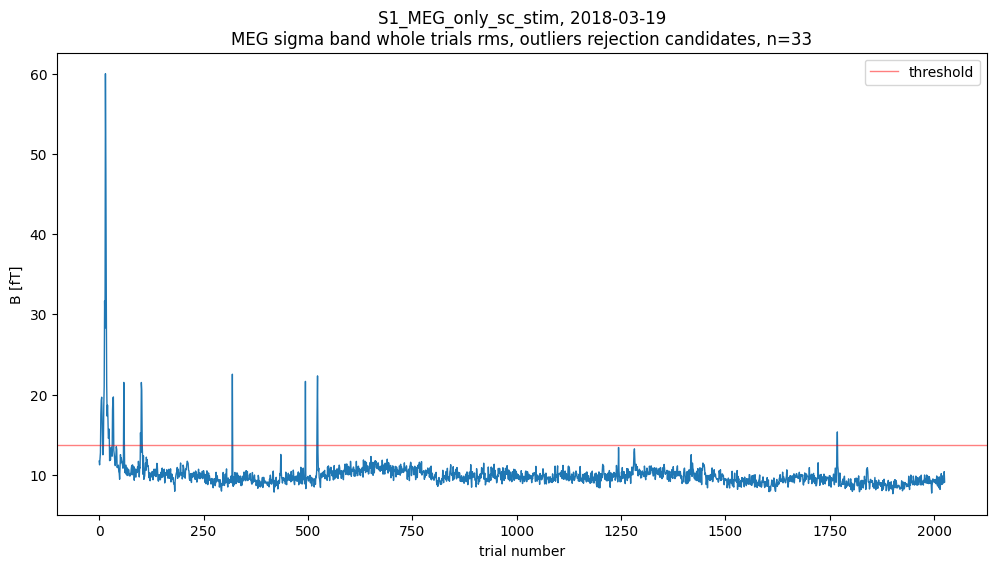

In [22]:
# calculate sigma band whole trials rms and percentiles to remove outliers
sigma_band_trials_rms = np.sqrt(np.mean(sigma_band_whole_trials**2, axis=0))

sigma_band_rms_q25 = scipy.stats.scoreatpercentile(sigma_band_trials_rms, 25)
sigma_band_rms_q50 = np.median(sigma_band_trials_rms)
sigma_band_rms_q75 = scipy.stats.scoreatpercentile(sigma_band_trials_rms, 75)
sigma_band_rms_iqr = sigma_band_rms_q75 - sigma_band_rms_q25

# set a high threshold to remove only very outliers
threshold_sigma_band_rms = sigma_band_rms_q75 + 3*sigma_band_rms_iqr
not_outliers_sigma_band = sigma_band_trials_rms <= threshold_sigma_band_rms

data_y = sigma_band_trials_rms
plt.plot(np.clip(data_y, 0, 60), linewidth=1)
plt.axhline(threshold_sigma_band_rms, linewidth=1, alpha=0.5, color='red', label='threshold')

plt_header('MEG sigma band whole trials rms, outliers rejection candidates, n=%d' % np.sum(data_y > threshold_sigma_band_rms))
plt.xlabel('trial number')
plt.ylabel(unit)
plt.legend()
plt_show_save_fig()

--------------------
Fig12.png


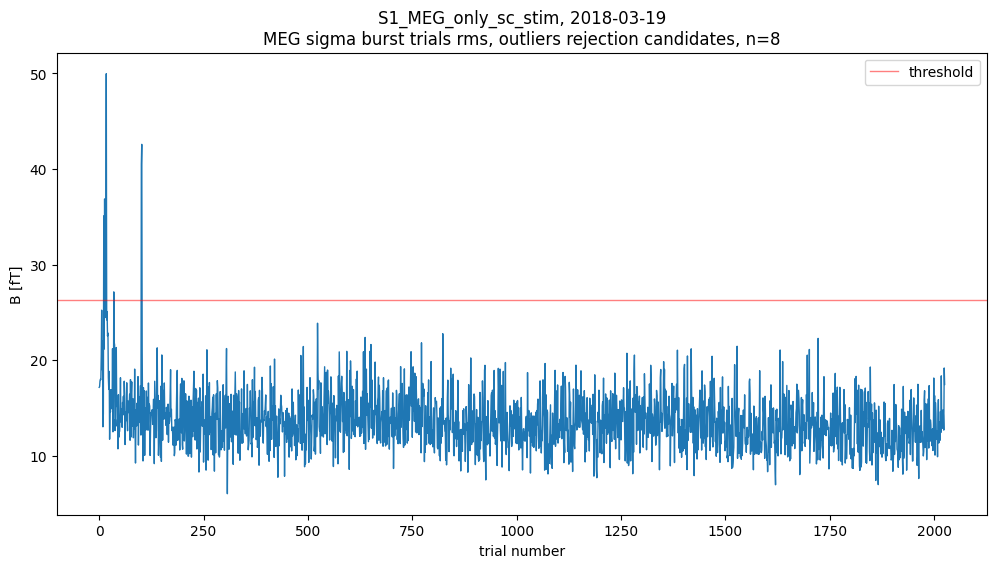

In [23]:
# calculate sigma burst trials rms and percentiles to remove outliers
sigma_burst_trials_rms = np.sqrt(np.mean(sigma_burst_trials**2, axis=0))

sigma_burst_rms_q25 = scipy.stats.scoreatpercentile(sigma_burst_trials_rms, 25)
sigma_burst_rms_q50 = np.median(sigma_burst_trials_rms)
sigma_burst_rms_q75 = scipy.stats.scoreatpercentile(sigma_burst_trials_rms, 75)
sigma_burst_iqr = sigma_burst_rms_q75 - sigma_burst_rms_q25

# set a high threshold to remove only very outliers
threshold_sigma_burst_rms = sigma_burst_rms_q75 + 3*sigma_burst_iqr
not_outliers_sigma_burst = sigma_burst_trials_rms <= threshold_sigma_burst_rms

data_y = sigma_burst_trials_rms
plt.plot(np.clip(data_y, 0, 60), linewidth=1)
plt.axhline(threshold_sigma_burst_rms, linewidth=1, alpha=0.5, color='red', label='threshold')

plt_header('MEG sigma burst trials rms, outliers rejection candidates, n=%d' % np.sum(data_y > threshold_sigma_burst_rms))
plt.xlabel('trial number')
plt.ylabel(unit)
plt.legend()
plt_show_save_fig()

--------------------
Fig13.png


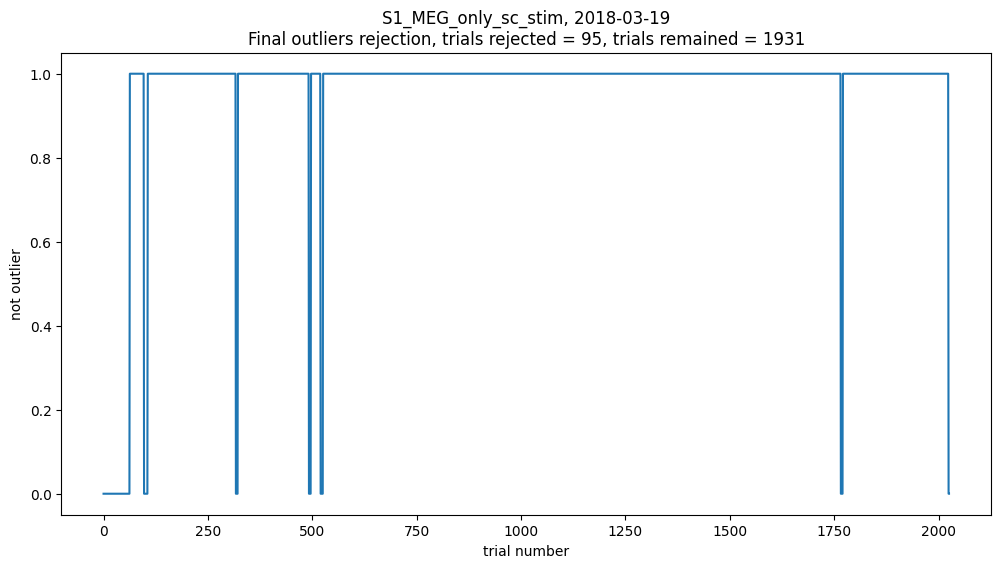

In [24]:
# final outliers estimation

not_outliers = not_outliers_sigma_band*not_outliers_sigma_burst

not_outliers = np.convolve(not_outliers, np.ones(5)/5, mode='same')
not_outliers = (not_outliers > 0.999)

not_outliers_arr = []
temp_arr = []

last_value = False
for i in range(len(not_outliers)):
    if(not_outliers[i] == False and last_value == True):
        not_outliers_arr.append(temp_arr)
        temp_arr = []

    if(not_outliers[i] == True):
        temp_arr.append(i)
    
    last_value = not_outliers[i]

for i in range(len(not_outliers_arr)):
    if(len(not_outliers_arr[i]) < 20):
        not_outliers[not_outliers_arr[i]] = False

plt_header('Final outliers rejection, trials rejected = %d, trials remained = %d' % (np.sum(not_outliers == False), np.sum(not_outliers)))
plt.plot(not_outliers)
plt.xlabel('trial number')
plt.ylabel('not outlier')
plt_show_save_fig()

(6115, 1931)
(6115, 1931)
(6115, 1931)
(500, 1931)
(1931,)
(1931,)
--------------------
Fig14.png


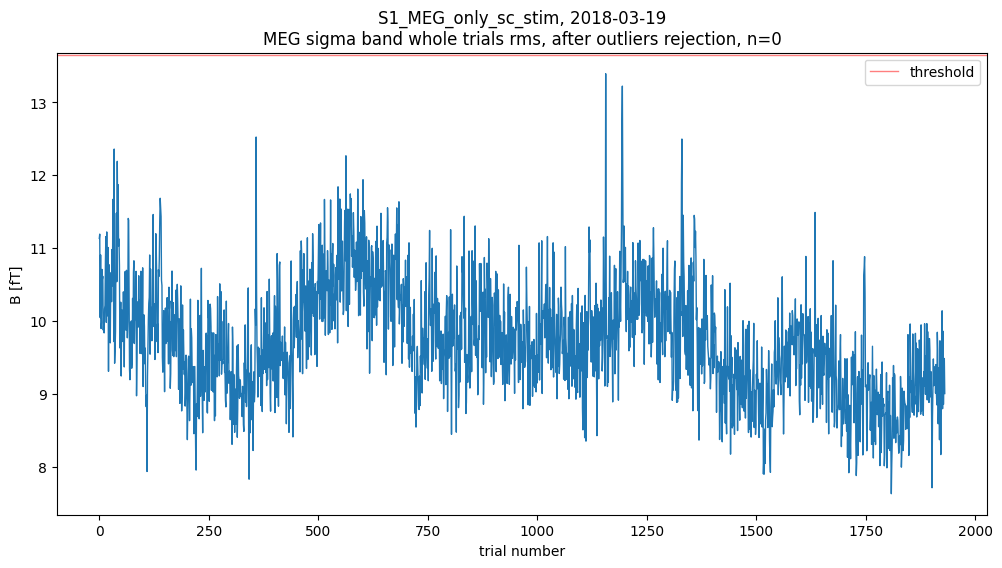

--------------------
Fig15.png


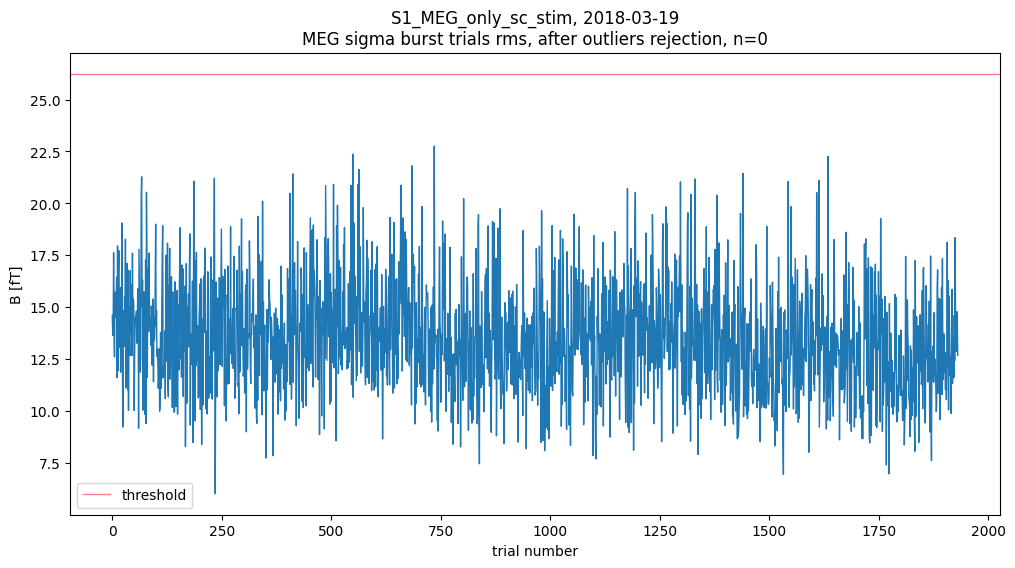

In [25]:
# reject outliers

XEG_whole_trials = XEG_whole_trials[:,not_outliers]
XEG_with_spectrum_peaks_whole_trials = XEG_with_spectrum_peaks_whole_trials[:,not_outliers]
sigma_band_whole_trials = sigma_band_whole_trials[:,not_outliers]
sigma_burst_trials = sigma_burst_trials[:,not_outliers]
sigma_band_trials_rms = sigma_band_trials_rms[not_outliers]
sigma_burst_trials_rms = sigma_burst_trials_rms[not_outliers]

print(XEG_whole_trials.shape)
print(XEG_with_spectrum_peaks_whole_trials.shape)
print(sigma_band_whole_trials.shape)
print(sigma_burst_trials.shape)
print(sigma_band_trials_rms.shape)
print(sigma_burst_trials_rms.shape)

data_y = sigma_band_trials_rms
plt.plot(np.clip(data_y, 0, 60), linewidth=1)
plt.axhline(threshold_sigma_band_rms, linewidth=1, alpha=0.5, color='red', label='threshold')

plt_header('MEG sigma band whole trials rms, after outliers rejection, n=%d' % np.sum(data_y > threshold_sigma_band_rms))
plt.xlabel('trial number')
plt.ylabel(unit)
plt.legend()
plt_show_save_fig()

data_y = sigma_burst_trials_rms
plt.plot(np.clip(data_y, 0, 60), linewidth=1)
plt.axhline(threshold_sigma_burst_rms, linewidth=1, alpha=0.5, color='red', label='threshold')

plt_header('MEG sigma burst trials rms, after outliers rejection, n=%d' % np.sum(data_y > threshold_sigma_burst_rms))
plt.xlabel('trial number')
plt.ylabel(unit)
plt.legend()
plt_show_save_fig()

In [26]:
# concatenate trials without outliers

XEG_data_no_outliers = np.concatenate(XEG_whole_trials.T)
XEG_with_spectrum_peaks_data_no_outliers = np.concatenate(XEG_with_spectrum_peaks_whole_trials.T)
all_stimuli_no_outliers = (np.arange(XEG_whole_trials.shape[1])*XEG_whole_trials.shape[0])
marker_no_outliers = all_stimuli_no_outliers[1:]
XEG_data_no_outliers = meet.interpolateEEG(XEG_data_no_outliers, marker_no_outliers, interpolate_win)
XEG_with_spectrum_peaks_data_no_outliers = meet.interpolateEEG(XEG_with_spectrum_peaks_data_no_outliers, marker_no_outliers, interpolate_win)

--------------------
Fig16.png


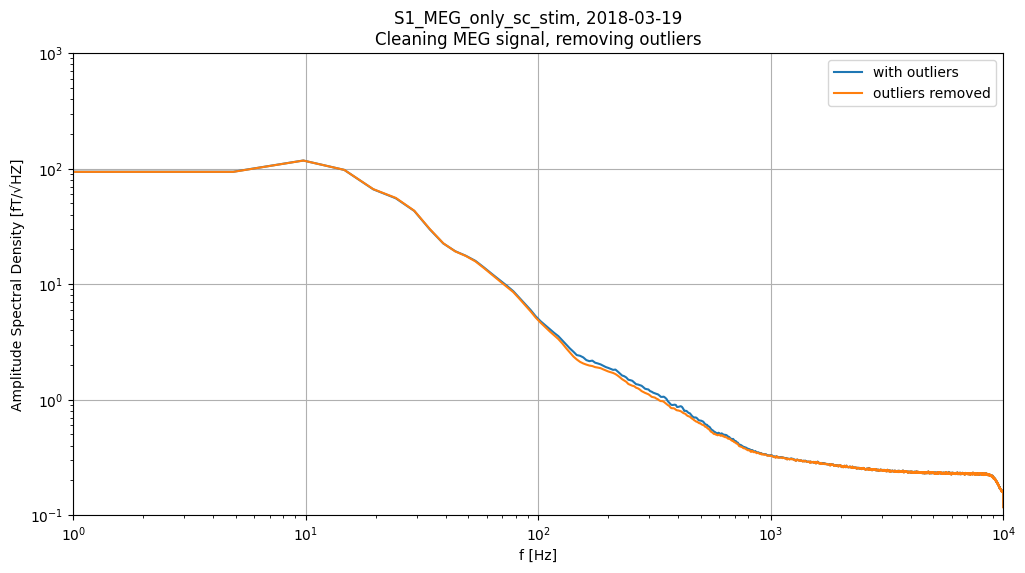

In [27]:
# plot asd of data with outliers removed

data = XEG_data
nfft = 2**(int(np.log2(srate))-2)
xf, yf = asd(data, nfft)

plt_header('Cleaning %s signal, removing outliers' % measurement_type)
plt.plot(xf, yf, label='with outliers')

data = XEG_data_no_outliers
xf, yf = asd(data, nfft)

plt.plot(xf, yf, label='outliers removed')
plt.xscale('log')
plt.yscale('log')
plt.xlim((1,srate//2))
if(measurement_type == 'EEG'):
    plt.ylim((0.001, 10))
else:
    plt.ylim((0.1, 1000))
plt.xlabel('f [Hz]')
plt.ylabel('Amplitude Spectral Density %s' % asd_unit)
plt.legend()
plt.grid(True)
plt_show_save_fig()

--------------------
Fig17.png


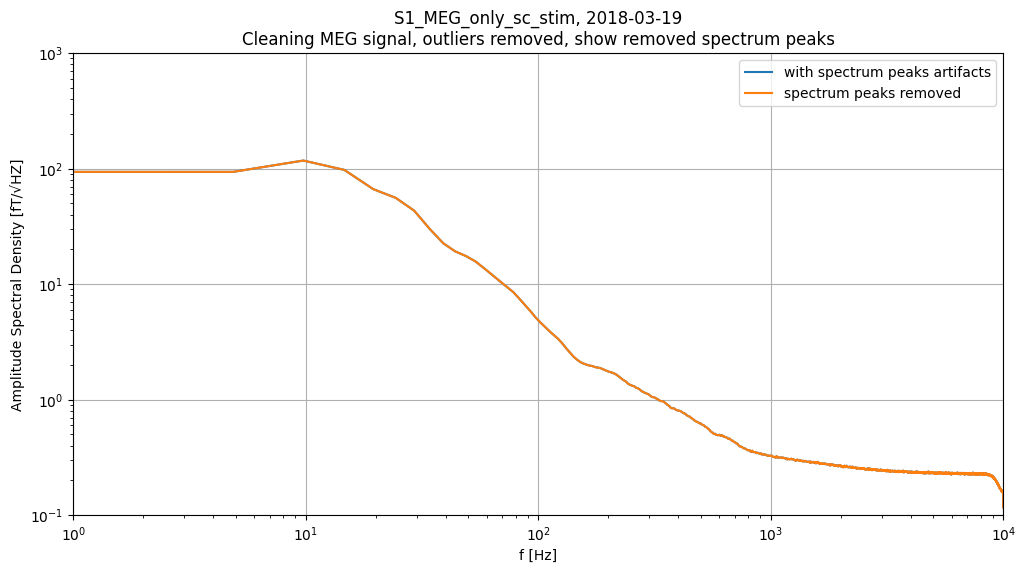

In [28]:
# plot asd of data with outliers removed, compare data with and without spectrum peaks

data = XEG_with_spectrum_peaks_data_no_outliers
nfft = 2**(int(np.log2(srate))-2)
xf, yf = asd(data, nfft)

plt_header('Cleaning %s signal, outliers removed, show removed spectrum peaks' % measurement_type)
plt.plot(xf, yf, label='with spectrum peaks artifacts')

data = XEG_data_no_outliers
xf, yf = asd(data, nfft)

plt.plot(xf, yf, label='spectrum peaks removed')
plt.xscale('log')
plt.yscale('log')
plt.xlim((1,srate//2))
if(measurement_type == 'EEG'):
    plt.ylim((0.001, 10))
else:
    plt.ylim((0.1, 1000))
plt.xlabel('f [Hz]')
plt.ylabel('Amplitude Spectral Density %s' % asd_unit)
plt.legend()
plt.grid(True)
plt_show_save_fig()

In [29]:
XEG_data = XEG_data_no_outliers
all_stimuli = all_stimuli_no_outliers
marker = marker_no_outliers

--------------------
Fig18.png


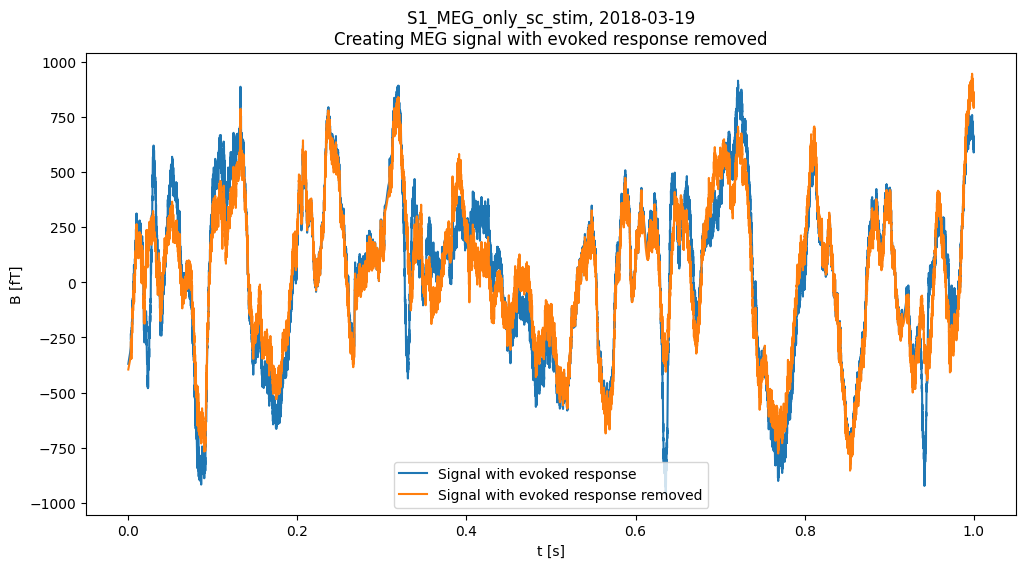

In [30]:
# create additional signal with evoked response removed

XEG_whole_trials_mean = np.mean(XEG_whole_trials, axis=-1)
XEG_data_no_mean = np.concatenate(XEG_whole_trials.T - XEG_whole_trials_mean)
XEG_data_no_mean = meet.interpolateEEG(XEG_data_no_mean, marker, interpolate_win)

data = XEG_data[:srate]
data_x = np.linspace(0, (len(data)-1)/srate, len(data))
data_y = data
plt.plot(data_x, data_y, label='Signal with evoked response')

data = XEG_data_no_mean[:srate]
data_x = np.linspace(0, (len(data)-1)/srate, len(data))
data_y = data
plt.plot(data_x, data_y, label='Signal with evoked response removed')

plt_header('Creating %s signal with evoked response removed' % measurement_type)
plt.xlabel('t [s]')
plt.ylabel(unit)
plt.legend()
plt_show_save_fig()

--------------------
Fig19.png


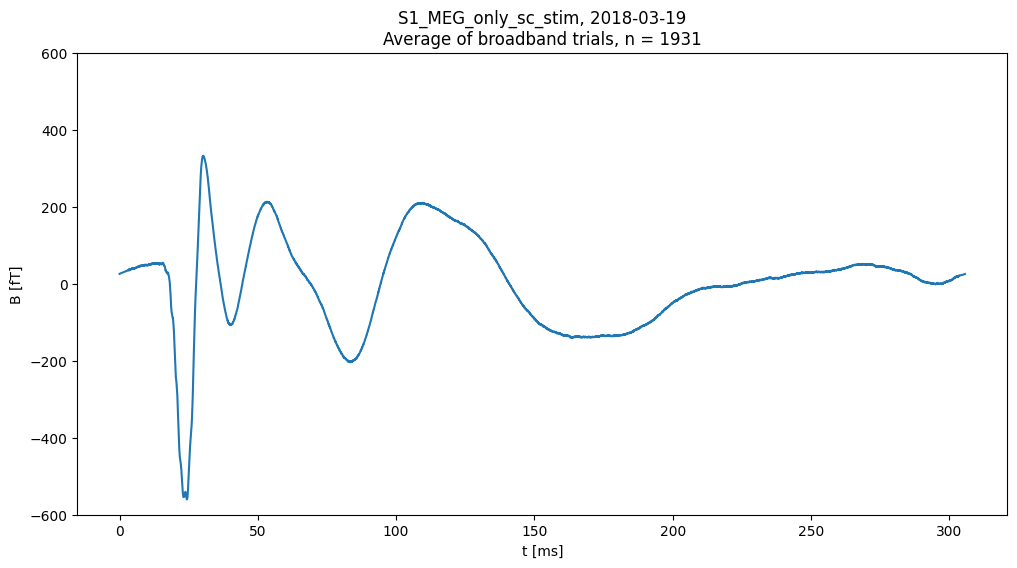

--------------------
Fig20.png


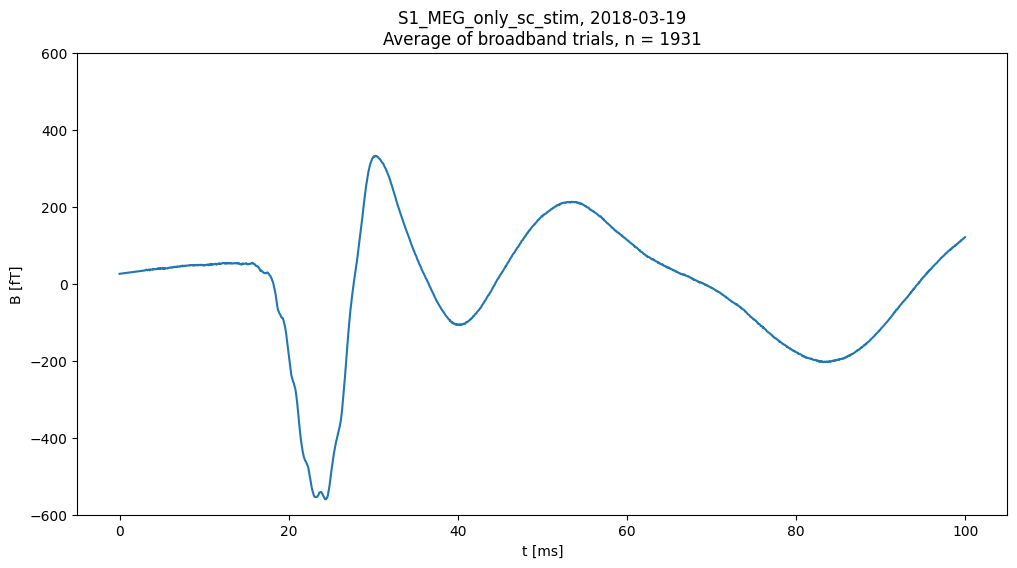

In [31]:
# plot broadband evoked response

data = XEG_whole_trials_mean
data_x = np.linspace(0, (len(data)-1)/srate, len(data))*1000
data_y = data
plt.plot(data_x, data_y)
plt_header('Average of broadband trials, n = %d' % len(XEG_whole_trials.T))
plt.xlabel('t [ms]')
plt.ylabel(unit)
if(measurement_type == 'EEG'):
    plt.ylim((-6.5, 6.5))
else:
    plt.ylim((-600, 600))
plt_show_save_fig()

data = XEG_whole_trials_mean[:srate//10]
data_x = np.linspace(0, (len(data)-1)/srate, len(data))*1000
data_y = data
plt.plot(data_x, data_y)
plt_header('Average of broadband trials, n = %d' % len(XEG_whole_trials.T))
plt.xlabel('t [ms]')
plt.ylabel(unit)
if(measurement_type == 'EEG'):
    plt.ylim((-5, 5))
else:
    plt.ylim((-600, 600))
plt_show_save_fig()

--------------------
Fig21.png


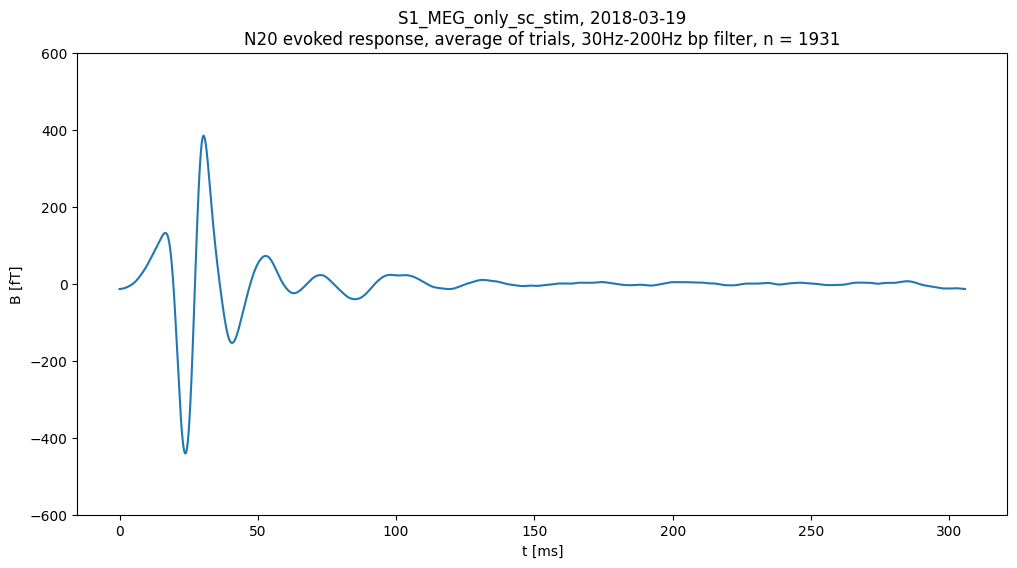

--------------------
Fig22.png


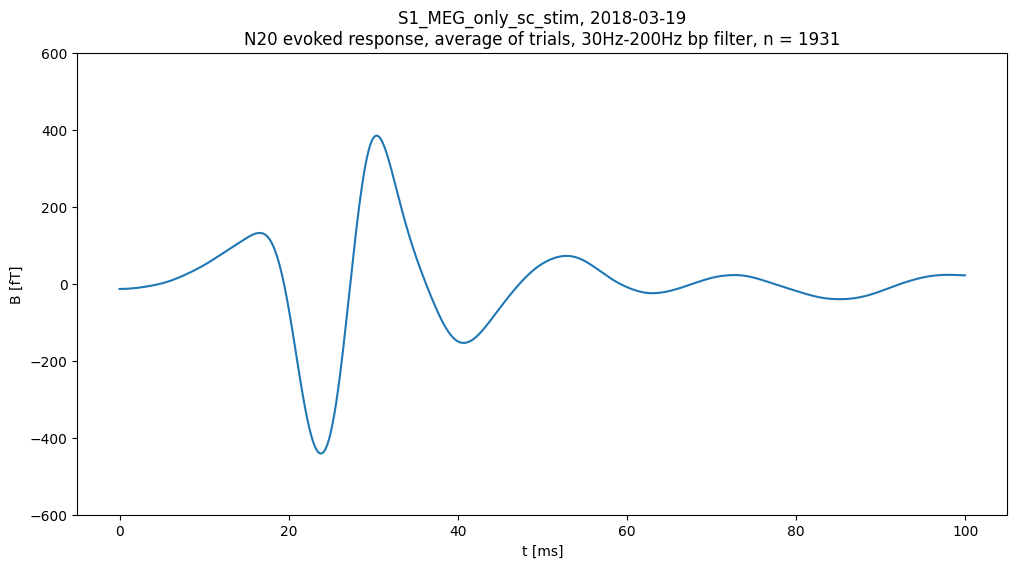

In [32]:
# extract and plot N20 somatosensory evoked response

# apply 30Hz-200Hz band-pass filter for N20 response extraction
sos = sig.butter(2, [30, 200], 'bandpass', fs=srate, output='sos')
n20_response_data = sig.sosfiltfilt(sos, XEG_data)
n20_response_trials = meet.epochEEG(n20_response_data, marker, whole_trial_win_samples)

n20_response_trials_mean = np.mean(n20_response_trials, axis=-1)

data = n20_response_trials_mean
data_x = np.linspace(0, (len(data)-1)/srate, len(data))*1000
data_y = data
plt.plot(data_x, data_y)
plt_header('N20 evoked response, average of trials, 30Hz-200Hz bp filter, n = %d' % len(sigma_band_whole_trials.T))
plt.xlabel('t [ms]')
plt.ylabel(unit)
if(measurement_type == 'EEG'):
    plt.ylim((-4, 4))
else:
    plt.ylim((-600, 600))
plt_show_save_fig()

data = n20_response_trials_mean[:srate//10]
data_x = np.linspace(0, (len(data)-1)/srate, len(data))*1000
data_y = data
plt.plot(data_x, data_y)
plt_header('N20 evoked response, average of trials, 30Hz-200Hz bp filter, n = %d' % len(sigma_band_whole_trials.T))
plt.xlabel('t [ms]')
plt.ylabel(unit)
if(measurement_type == 'EEG'):
    plt.ylim((-4, 4))
else:
    plt.ylim((-600, 600))
plt_show_save_fig()

--------------------
Fig23.png


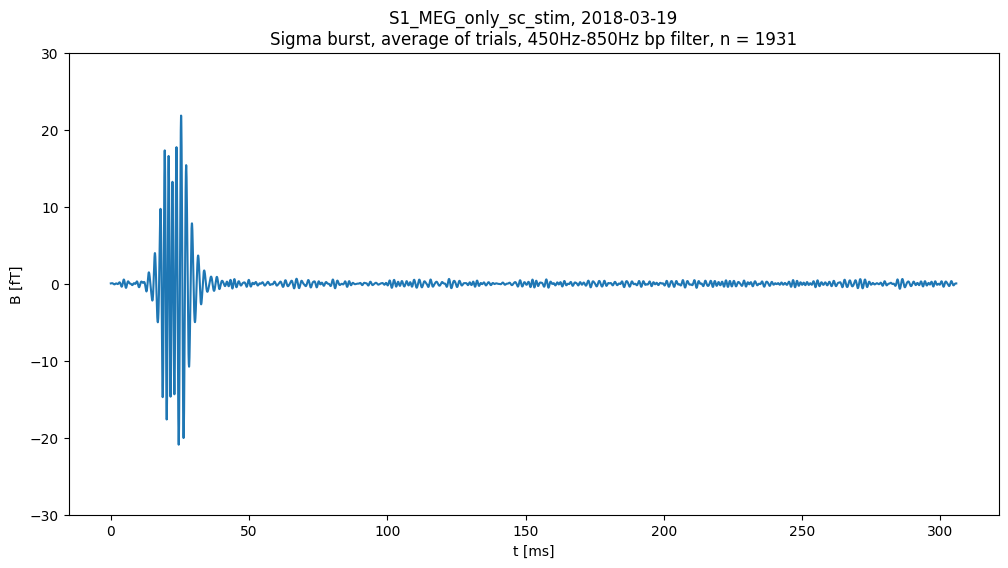

--------------------
Fig24.png


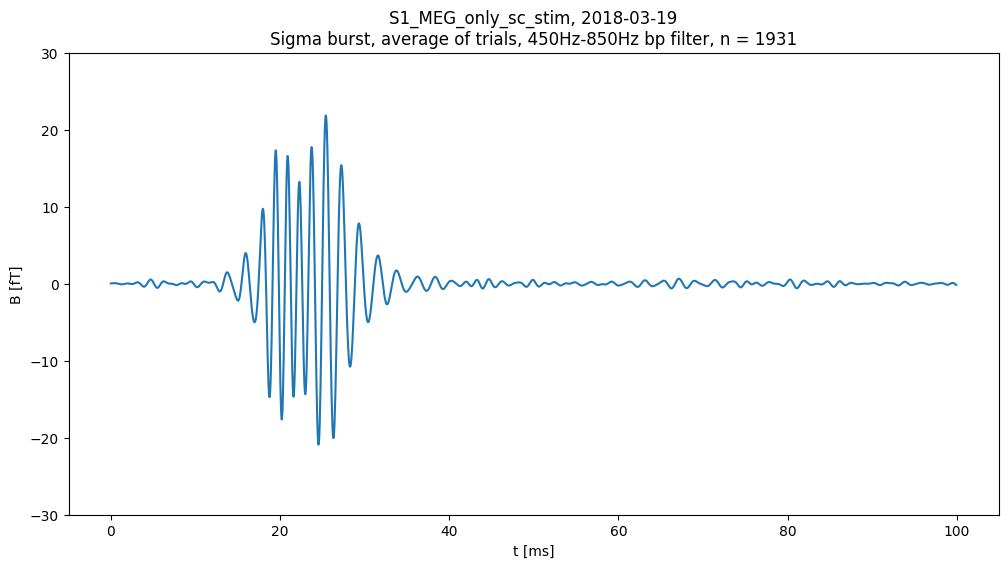

In [33]:
# plot sigma burst (high-frequency somatosensory evoked response)

sigma_band_whole_trials_mean = np.mean(sigma_band_whole_trials, axis=-1)

data = sigma_band_whole_trials_mean
data_x = np.linspace(0, (len(data)-1)/srate, len(data))*1000
data_y = data
plt.plot(data_x, data_y)
plt_header('Sigma burst, average of trials, 450Hz-850Hz bp filter, n = %d' % len(sigma_band_whole_trials.T))
plt.xlabel('t [ms]')
plt.ylabel(unit)
if(measurement_type == 'EEG'):
    plt.ylim((-0.3, 0.3))
else:
    plt.ylim((-30, 30))
plt_show_save_fig()

data = sigma_band_whole_trials_mean[:srate//10]
data_x = np.linspace(0, (len(data)-1)/srate, len(data))*1000
data_y = data
plt.plot(data_x, data_y)
plt_header('Sigma burst, average of trials, 450Hz-850Hz bp filter, n = %d' % len(sigma_band_whole_trials.T))
plt.xlabel('t [ms]')
plt.ylabel(unit)
if(measurement_type == 'EEG'):
    plt.ylim((-0.3, 0.3))
else:
    plt.ylim((-30, 30))
plt_show_save_fig()

--------------------
Fig25.png


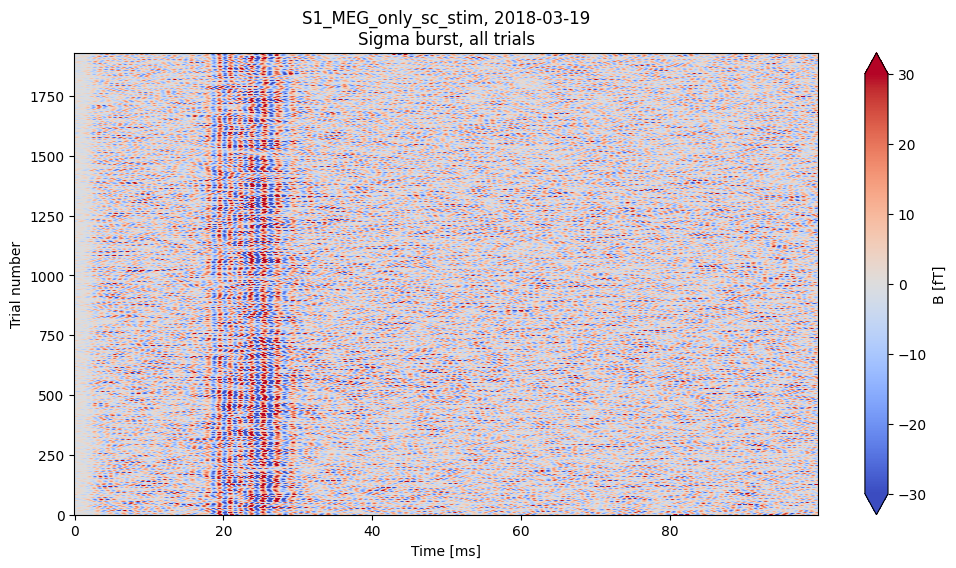

--------------------
Fig26.png


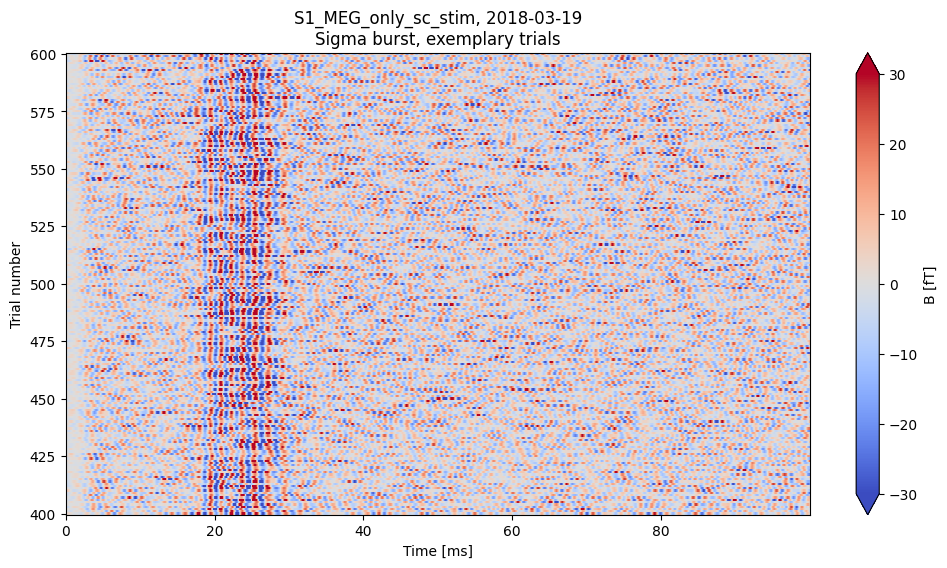

In [34]:
# plot sigma burst single trials stack on each other

plt.rcParams['image.cmap'] = 'coolwarm'

plt_header('Sigma burst, all trials')
data = sigma_band_whole_trials[:srate//10,]
data_x = np.linspace(0, 1000*(len(data)-1)/srate, len(data))

if(measurement_type == 'MEG'):
    limit = 30
else:
    limit = 0.6

plt.pcolormesh(data_x, np.arange(len(data.T)), data.T, vmin=-limit, vmax=limit)
plt.ylabel('Trial number')
plt.xlabel('Time [ms]')
clb = plt.colorbar(extend='both')
clb.set_label(unit)
plt_show_save_fig()

start_trial = 400
end_trial = 600
plt_header('Sigma burst, exemplary trials')
data = sigma_band_whole_trials[:srate//10,start_trial:end_trial+1]
data_x = np.linspace(0, 1000*(len(data)-1)/srate, len(data))

plt.pcolormesh(data_x, np.arange(start_trial, end_trial+1), data.T, vmin=-limit, vmax=limit)
plt.ylabel('Trial number')
plt.xlabel('Time [ms]')
clb = plt.colorbar(extend='both')
clb.set_label(unit)
plt_show_save_fig()

In [35]:
# save the preprocessed data

stimulus_new = np.zeros(len(XEG_data))
stimulus_new[marker_no_outliers] = 1.0

out_data = np.stack((XEG_data, XEG_data_no_mean, stimulus_new))
os.makedirs(data_output_folder, exist_ok=True)
np.save(os.path.join(data_output_folder, filename+'.npy'), out_data)